In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

Utilizaré para este ejercicio una librería de más de 60000 imágenes propias de Zalando, estas ya están en 28x28 y en blanco y negro

Voy a usar tensorflow_datasets para descargar las imágenes y sus metadatos

In [3]:
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

c:\Users\mateo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 4/4 [00:01<00:00,  3.32 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:01<00:00,  2.76 url/s]
                                                                        

Dataset fashion_mnist downloaded and prepared to C:\Users\mateo\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [4]:
# Separamos los datos de entrenamiento y prueba
datos_entrenamiento, datos_prueba = datos['train'], datos['test']

In [5]:
# Conseguimos los nombres de las categorias que vienen en el set
nombres_clases = metadatos.features['label'].names

In [6]:
# Normalizar los datos (Pasar de 0-255 a 0-1)

def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 # Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

# Normalizar los datos de entrenamiento y pruebas con la funcion
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_prueba = datos_prueba.map(normalizar)

# Agregar cache (usar memoria en lugar de disco)
datos_entrenamiento = datos_entrenamiento.cache()
datos_prueba = datos_prueba.cache()

<function matplotlib.pyplot.show(close=None, block=None)>

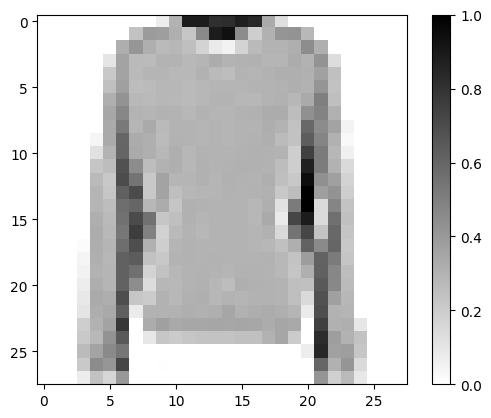

In [7]:
# Mostrar una imagen de los datos de pruebas, de momento la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28, 28)) # Redimensionar

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show

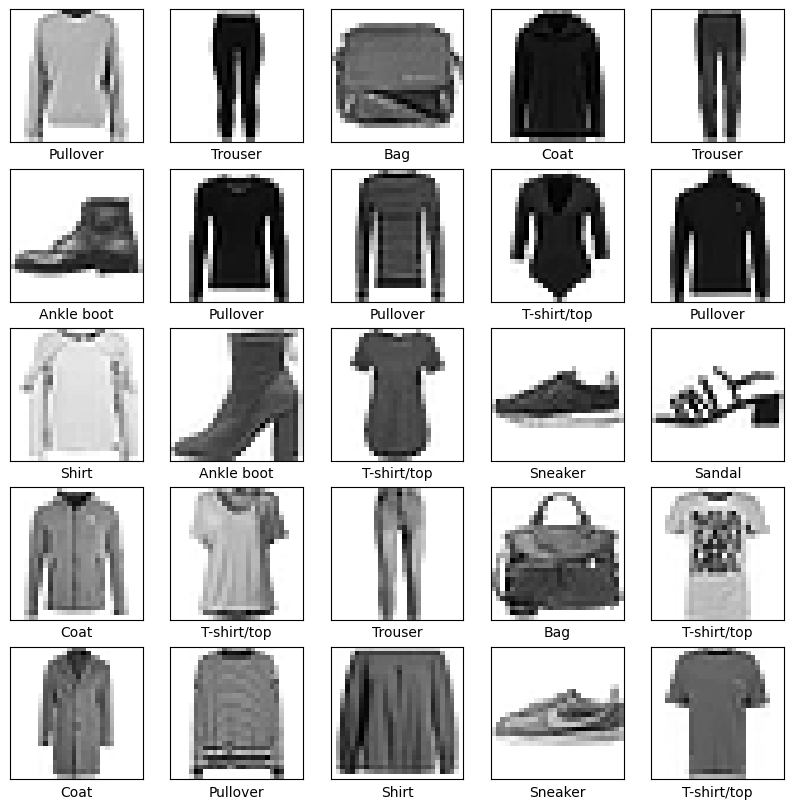

In [8]:
# Mostrar varias imágenes junto con su clase
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28, 28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [9]:
# Crear modelo de tipo secuencial, definimos varias capas, 2 capas ocultas densas con 50 neuronas cada una y con la activación relu (ya que no nos sirve que sea lineal) y una capa de salida con 10 neuronas
modelo = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)), # 1 - blanco y negro
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) # Para redes de clasificación para asegurar que la suma de las redes de salida siempre de 1
])

c:\Users\mateo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Compilar el modelo
modelo.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
  )

In [11]:
# Conseguimos el numero de entrenamiento y pruebas
num_ej_entrenamiento = metadatos.splits['train'].num_examples
num_ej_prueba = metadatos.splits['test'].num_examples

In [12]:
# Para que la red funcione mas rapido se puede definir que funcione por lotes
TAMANO_LOTE = 32

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_prueba = datos_prueba.batch(TAMANO_LOTE)

In [13]:
import math

# Entrenar el modelo
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 794us/step - accuracy: 0.7506 - loss: 0.7043
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.8558 - loss: 0.3967
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 816us/step - accuracy: 0.8723 - loss: 0.3529
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 800us/step - accuracy: 0.8785 - loss: 0.3364
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.8841 - loss: 0.3143


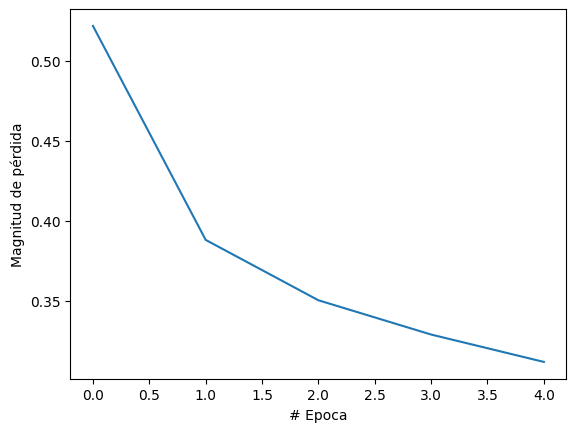

In [14]:
# Ver la funcion de perdida
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


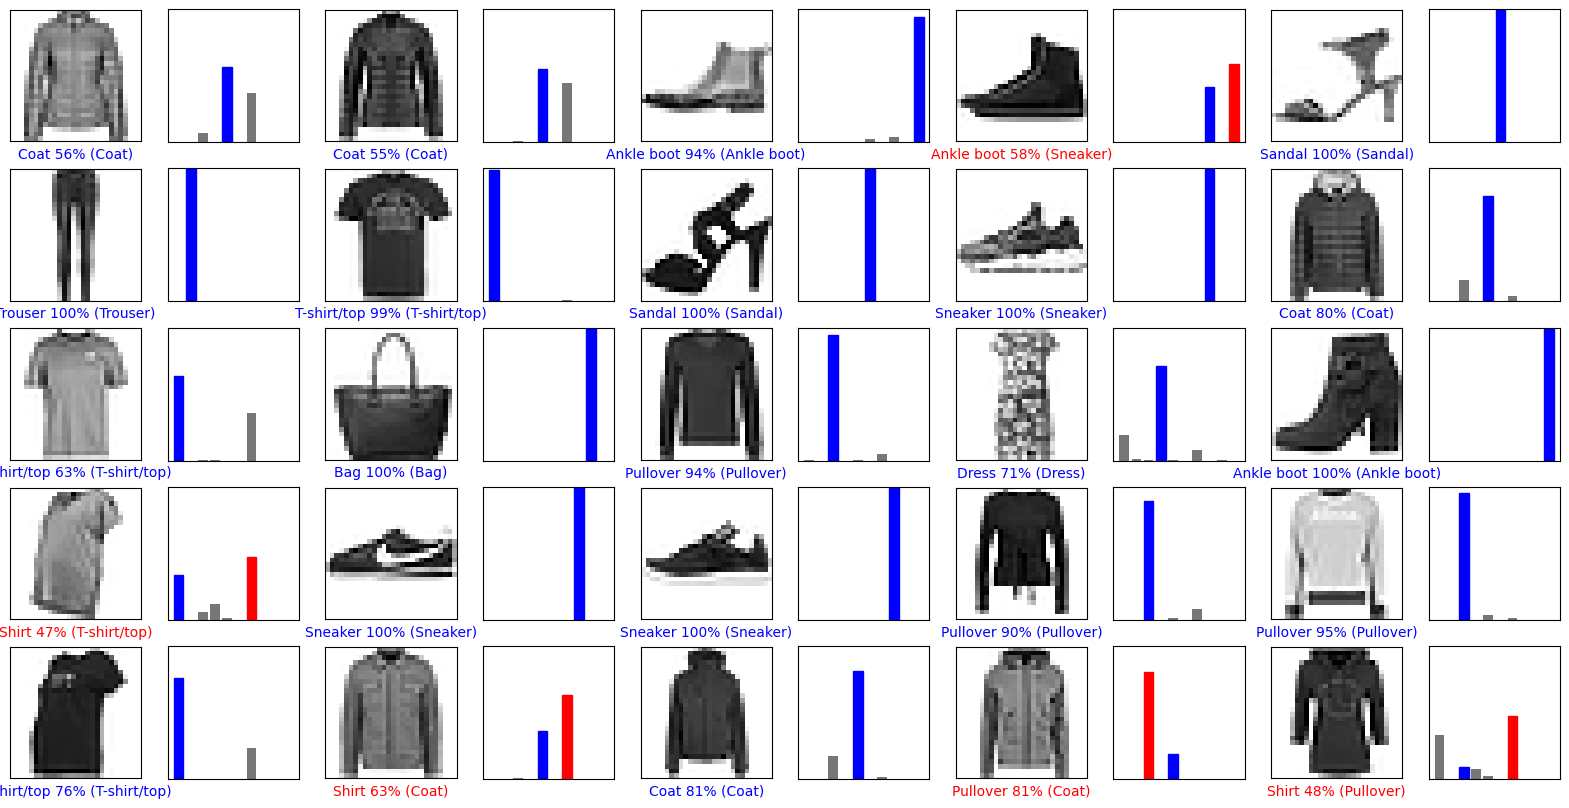

In [15]:
# Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_prueba.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [16]:
# Coger cualquier indeice del set de pruebas para ver su prediccion
imagen = imagenes_prueba[10]
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print(f"Prediccion: {nombres_clases[np.argmax(prediccion[0])]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediccion: T-shirt/top


In [17]:
# Exportar el modelo a un navegador
modelo.save('modelo_exportado.h5')

In [18]:
# Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
%pip install tensorflowjs

Note: you may need to restart the kernel to use updated packages.Collecting tensorflowjs
     ---------------------------------------- 0.0/15.2 MB ? eta -:--:--
      --------------------------------------- 0.2/15.2 MB 7.3 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/15.2 MB 18.5 MB/s eta 0:00:01
     -------- ------------------------------- 3.2/15.2 MB 33.9 MB/s eta 0:00:01
     --------- ------------------------------ 3.8/15.2 MB 26.7 MB/s eta 0:00:01
     ------------ --------------------------- 4.7/15.2 MB 27.1 MB/s eta 0:00:01
     ----------------- ---------------------- 6.6/15.2 MB 32.3 MB/s eta 0:00:01
     ----------------------- ---------------- 8.8/15.2 MB 35.1 MB/s eta 0:00:01
     -------------------------- ------------ 10.2/15.2 MB 36.2 MB/s eta 0:00:01
     ----------------------------- --------- 11.6/15.2 MB 43.5 MB/s eta 0:00:01
     --------------------------------- ----- 13.0/15.2 MB 40.9 MB/s eta 0:00:01
     -----------------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
black 24.4.2 requires packaging>=22.0, but you have packaging 20.9 which is incompatible.


In [19]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

2024-07-03 18:50:16.611869: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 18:50:17.467961: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
c:\Users\mateo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflowjs\read_weights.py:28: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.uint8, np.uint16, np.object, np.bool]
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\mateo\AppData\

In [20]:
# Comprobacion de si creo la carpeta
!ls

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [21]:
# Ver el contenido de la carpeta
!ls tfjs_target_dir

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
